In [5]:
# !pip install bbknn
print('Install bbknn')
import bbknn

Install bbknn


In [6]:
import numpy as np
# import bbknn
# import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4+18.gaabe446 anndata==0.6.17 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [7]:
# Create folder to save the results 
import os
dirname = os.getcwd()
print(dirname)
data_dir = os.path.join(dirname, './data/')
# if not os.path.exists('./results_cellatlas/'): os.makedirs('./results_cellatlas/')

if not os.path.exists('./results_cellatlas/bbknn_results_v2/'): os.makedirs('./results_cellatlas/bbknn_results_v2/')
    
save_dir = os.path.join(dirname, 'results_cellatlas/bbknn_results_v2/')
def save_images(basename):
    if not os.path.exists('./figures_cellatlas/'): os.makedirs('./figures_cellatlas/')
    
    if not os.path.exists('./figures_cellatlas/bbknn_results_v2/'): os.makedirs('./figures_cellatlas/bbknn_results_v2/')
    outname = './figures_cellatlas/bbknn_results_v2/' + basename + '.png'
    pl.savefig(outname, dpi=150)
    pl.close()

/acrc/jinmiao/CJM_lab/hoatran/python_workspace/batch_effect_manuscript


In [8]:
# read data from read count text table, data from R: genes x cells
# scale data by number of UMI first then load scaled data
# adata = sc.read_text(os.path.join(data_dir,'hvg_scaled_filtered_total_batch1_seqwell_batch2_10x_inverse.txt'),delimiter='\t',first_column_names=True,dtype='float64')
# print(adata)  
# print(adata.obs_names[1:3])
# print(adata.var_names[1:3])

# sample_adata = pd.read_csv(os.path.join(data_dir,'filtered_total_sample_ext_organ_celltype_batch.txt'),header=0, index_col=0, sep='\t')
# print(sample_adata.values.shape)
# print(sample_adata.keys())

# adata.obs['cell_type'] = sample_adata.loc[adata.obs_names,['ct']]
# adata.obs['batch'] = sample_adata.loc[adata.obs_names,['batch']]
# adata.obs['tissue'] = sample_adata.loc[adata.obs_names,['tissue']]
# adata.obs['organ'] = sample_adata.loc[adata.obs_names,['organ']]
# adata.obs['batchlb'] = sample_adata.loc[adata.obs_names,['batchlb']]
# print(len(adata.obs['cell_type']))
# print(len(adata.obs['batch']))
# Save output into h5ad, easy to access 
adata1 = sc.read_h5ad(os.path.join(data_dir,'hvg_dataset2_cellatlas.h5ad')) # filtered data, keep only hvg genes 6954 × 1328 
adata1

AnnData object with n_obs × n_vars = 6954 × 1328 
    obs: 'cell_type', 'batch', 'tissue', 'organ', 'batchlb'

AnnData object with n_obs × n_vars = 6954 × 1328 
    obs: 'cell_type', 'batch', 'tissue', 'organ', 'batchlb'


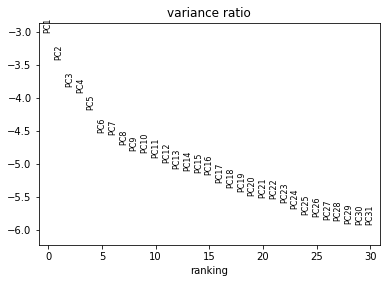

In [9]:
print(adata1)
# sc.pp.log1p(adata1)
# sc.pp.scale(adata1)
sc.tl.pca(adata1, svd_solver='arpack')
adata1.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_variance_ratio(adata1, log=True)
# sc.pp.neighbors(adata1,n_neighbors=10, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:09.73) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:26.84) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.68) --> found 26 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


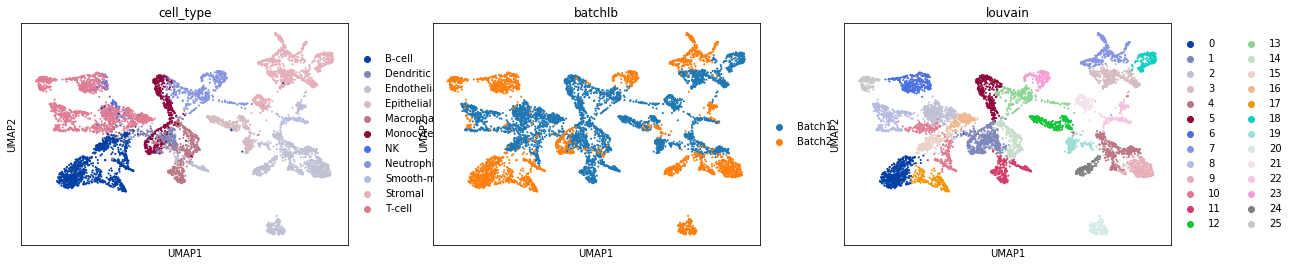

In [10]:
num_pcs = 20
sc.pp.neighbors(adata1,n_pcs=num_pcs, n_neighbors=20)
sc.tl.umap(adata1)
sc.tl.louvain(adata1)
color_group = ['cell_type','batchlb','louvain']
sc.pl.umap(adata1, color=color_group)

del adata1.uns['louvain_colors']

In [11]:
# BBKNN first input option
# input: batch vector in ann data

import time
from datetime import timedelta
t1 = time.time()
adata_bbknn = bbknn.bbknn(adata1, copy=True, neighbors_within_batch=5, trim=0, n_pcs=num_pcs, batch_key='batch') #approx=False,
t2 = time.time()
print('Took '+str(timedelta(seconds=t2-t1)))

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


computing batch balanced neighbors
	finished (0:00:08.45) --> added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix
Took 0:00:08.462040


computing UMAP
    finished (0:00:18.99) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.37) --> found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


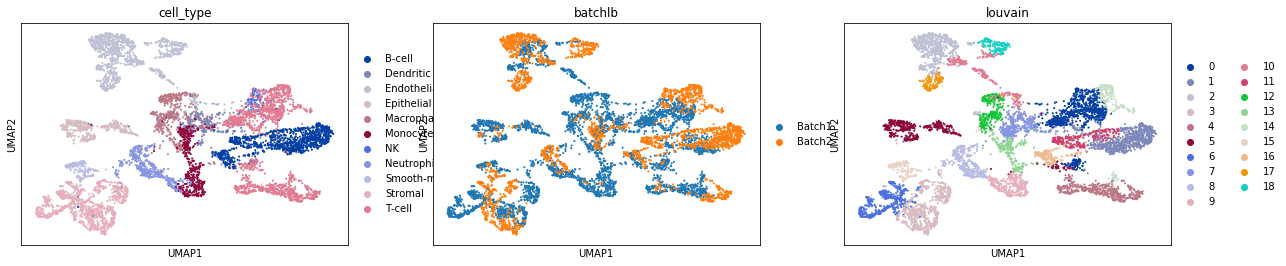

In [12]:
sc.tl.umap(adata_bbknn)
sc.tl.louvain(adata_bbknn)
# color_group = ["cell_type","batchlb","organ"]
color_group = ['cell_type','batchlb','louvain']
sc.pl.umap(adata_bbknn, color=color_group)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


computing batch balanced neighbors
	finished (0:00:03.41) --> added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix
Took 0:00:03.415726
computing UMAP
    finished (0:00:18.78) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.43) --> found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


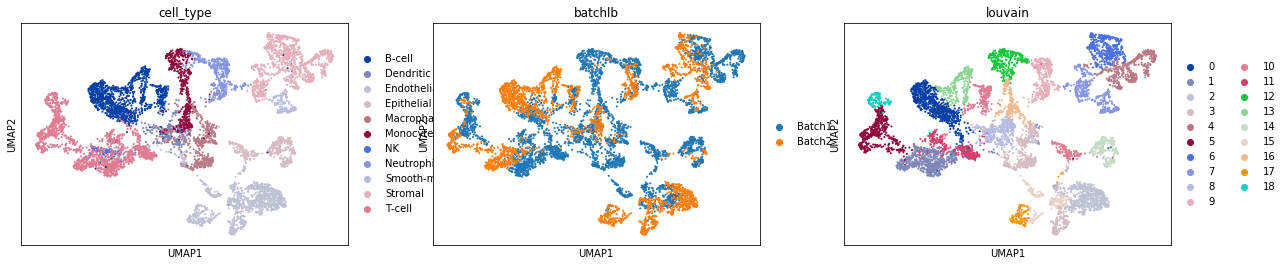

In [13]:
# BBKNN uses adata.obs['batch'] by default to split the batches
# BBKNN also offers a trim parameter, which filters each cell's connections 
# to a user-specified number of highest connectivities. 
# This can help increase cell type separation at a potential slight cost to batch mixing
t3 = time.time()
adata_bbknn_trim = bbknn.bbknn(adata1,copy=True,neighbors_within_batch=5,trim=50,n_pcs=num_pcs,batch_key='batch') #approx=False,
t4 = time.time()
print('Took '+str(timedelta(seconds=t4-t3)))
sc.tl.umap(adata_bbknn_trim)
sc.tl.louvain(adata_bbknn_trim)
color_group = ['cell_type','batchlb','louvain']
sc.pl.umap(adata_bbknn_trim, color=color_group)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


computing batch balanced neighbors
	finished (0:00:03.19) --> added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix
Took 0:00:03.195120
computing UMAP
    finished (0:00:18.58) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.37) --> found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


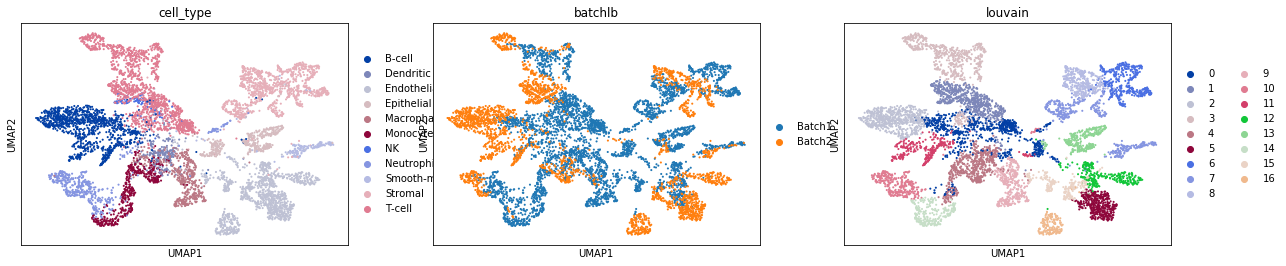

In [14]:
# Test different options and choose the best 
# By default, BBKNN uses annoy to compute approximate neighbours. 
# This has the potential to improve batch mixing, particularly in larger data, as connections will be present in the graph between more representatives of different batches. BBKNN does offer the option to compute exact neighbours, and does so by default via faiss. 
# The default metric changes from angular to Euclidean.
t5 = time.time()
adata_bbknn_faiss = bbknn.bbknn(adata1,copy=True,neighbors_within_batch=5,approx=False,n_pcs=num_pcs,batch_key='batch') #approx=False,
t6 = time.time()
print('Took '+str(timedelta(seconds=t6-t5)))
sc.tl.umap(adata_bbknn_faiss)
sc.tl.louvain(adata_bbknn_faiss)
color_group = ["cell_type","batchlb","louvain"]
sc.pl.umap(adata_bbknn_faiss, color=color_group)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


computing batch balanced neighbors
	finished (0:00:03.38) --> added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix
Took 0:00:03.388229
computing UMAP
    finished (0:00:18.83) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.30) --> found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


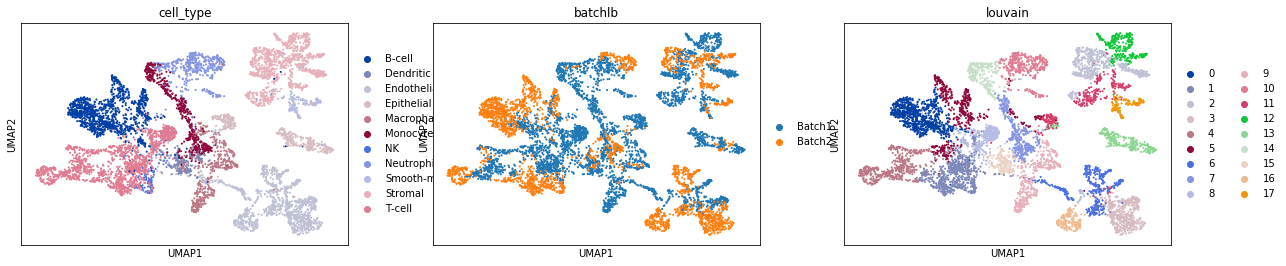

In [15]:
# Test different options and choose the best 
# ckdtree
# However, faiss is quite difficult to install, and temperamental in execution 
# (e.g. it doesn't work via reticulate on my machine). Setting use_faiss to False, 
# or just failing to have faiss installed, makes BBKNN use scipy.spatial.cKDTree at a performance loss.
t7 = time.time()
adata_bbknn_ckdtree = bbknn.bbknn(adata1, copy=True, neighbors_within_batch=5, approx=False, n_pcs=30,use_faiss=False,batch_key='batch') #approx=False,
t8 = time.time()
print('Took '+str(timedelta(seconds=t8-t7)))
sc.tl.umap(adata_bbknn_ckdtree)
sc.tl.louvain(adata_bbknn_ckdtree)
color_group = ["cell_type","batchlb","louvain"]
sc.pl.umap(adata_bbknn_ckdtree, color=color_group)


In [16]:
# from sklearn.metrics import silhouette_score
# import seaborn as sns
# sil_orig = silhouette_score(adata1.obsm.X_pca[:, :20], adata1.obs['batch'])
# # sil_true = silhouette_score(corrected_adata.obsm.X_pca[:, :2], adata_true.obs.Group)
# sil_corr = silhouette_score(adata_bbknn_trim.obsm.X_pca[:,:20], adata_bbknn_trim.obs['batch'])
# print('after correction: ',sil_corr)
# print('original: ',sil_orig)
# usecase_name = 'hvg_bbknn_cellatlas'
# data_sil = {'use_case':usecase_name, 'sil_filtered':sil_orig,
#        'sil_corrected': sil_corr} 
  
# # Creates pandas DataFrame. 
# df_score = pd.DataFrame(data_sil, index =['silscore'])
# print(df_score)
# # df_score.to_csv(save_dir+usecase_name+'.csv') 
# sil_score_ls = []
# sil_score_ls.append(sil_orig)
# sil_score_ls.append(sil_corr)
# label_sil = ['Filtered', 'bbknn_Normalized']
# sns.barplot(x=label_sil, y=sil_score_ls)
# pl.title('Silhouette Coef Batch Mixing')
# # save_images('bbknn_silhouette_coeff_batch_label')

In [17]:
sc.tl.pca(adata_bbknn_trim, svd_solver='arpack',n_comps=20)
print(adata_bbknn_trim)
adata_bbknn_trim.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
# adata_bbknn.write_csvs(save_dir, skip_data=False)
# adata_bbknn.write_h5ad(os.path.join(save_dir,'bbknn_dataset1_uc3.h5ad'))

AnnData object with n_obs × n_vars = 6954 × 1328 
    obs: 'cell_type', 'batch', 'tissue', 'organ', 'batchlb', 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'cell_type_colors', 'batchlb_colors', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


In [18]:
# Function to plot TSNE
def plotTSNE(adata, color_group, n_pcs=20, perplexity=90, save_filename='tsne', use_repx = False):
    #adata.var_names_make_unique()
    if use_repx:
        sc.tl.tsne(adata, random_state=0, n_pcs=n_pcs, perplexity=perplexity, use_rep='X')
    else:    
        sc.tl.tsne(adata, random_state=0, n_pcs=n_pcs, perplexity=perplexity)
    sc.pl.tsne(adata, color = color_group, show=False, wspace=.3)
    save_images(save_filename)     
    
    
def plotUMAP(adata, color_group, save_filename, use_repx = False):
    
#     if use_repx:
#         sc.pp.neighbors(adata, use_rep='X')
#     else:    
#         sc.pp.neighbors(adata,n_neighbors=10, n_pcs=20)
        
    sc.tl.umap(adata)
    sc.pl.umap(adata, color = color_group, show=False)
    save_images(save_filename) 
    

In [19]:
# Visualization
# color_group = ["batch","cell_type","organ"]
# plotUMAP(adata_bbknn_trim, color_group, 'bbknn_umap')
color_group = ['cell_type','batchlb','louvain']
sc.pl.umap(adata_bbknn_trim, color=color_group, show=False)
save_images('bbknn_umap_cellatlas') 
plotTSNE(adata_bbknn_trim, color_group, 20, 90, 'bbknn_tsne_cellatlas')

computing tSNE
    using 'X_pca' with n_pcs = 20
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:57.62) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [25]:
sc.pl.umap(adata1, color=color_group, show=False)
save_images('filtered_data_umap_cellatlas')

In [20]:
# Visualization
import pandas as pd
print(adata_bbknn_trim)
colnu = []
for i in range(adata_bbknn_trim.obsm['X_umap'].shape[1]):
    colnu.append("UMAP"+str(i+1))
df = pd.DataFrame(adata_bbknn_trim.obsm['X_umap'], columns=colnu, index=adata_bbknn_trim.obs_names)
df['batch'] = pd.Series(adata_bbknn_trim.obs['batch'], index=adata_bbknn_trim.obs_names)
df['celltype'] = pd.Series(adata_bbknn_trim.obs['cell_type'], index=adata_bbknn_trim.obs_names)
df['organ'] = pd.Series(adata_bbknn_trim.obs['organ'], index=adata_bbknn_trim.obs_names)
df.to_csv(save_dir + 'bbknn_umap.csv')

AnnData object with n_obs × n_vars = 6954 × 1328 
    obs: 'cell_type', 'batch', 'tissue', 'organ', 'batchlb', 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'cell_type_colors', 'batchlb_colors', 'louvain_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'


In [21]:
colnt = []
for i in range(adata_bbknn_trim.obsm['X_tsne'].shape[1]):
    colnt.append("tSNE_"+str(i+1))

df = pd.DataFrame(adata_bbknn_trim.obsm['X_tsne'], columns=colnt, index=adata_bbknn_trim.obs_names)
df['batch'] = pd.Series(adata_bbknn_trim.obs['batch'], index=adata_bbknn_trim.obs_names)
df['celltype'] = pd.Series(adata_bbknn_trim.obs['cell_type'], index=adata_bbknn_trim.obs_names)
df['organ'] = pd.Series(adata_bbknn_trim.obs['organ'], index=adata_bbknn_trim.obs_names)
df.to_csv(save_dir+'hvg_bbknn_tsne.csv') 

In [22]:
adata_bbknn_trim.obsm['X_pca'][:,:20].shape

(6954, 20)

In [23]:
# ASW 
def write_to_csv(mat, genesname, cellsname, filename, save_dir):
    if isinstance(mat, np.ndarray):
        df = pd.DataFrame(mat, columns=genesname, index=cellsname)
    else:
        df = pd.DataFrame(mat.toarray(), columns=genesname, index=cellsname)        
    
    df.to_csv(save_dir+filename)  
    
filename = 'bbknn_pca.csv'
coln_pca = []
for i in range(adata_bbknn.obsm['X_pca'][:,:20].shape[1]):
    coln_pca.append("X_pca"+str(i+1))
    

write_to_csv(adata_bbknn_trim.obsm['X_pca'], coln_pca, adata_bbknn_trim.obs_names,filename, save_dir)

In [24]:
print(t3)
print(t4)
time_taken = t4 - t3
time_taken_mins = divmod(time_taken, 60)
time_taken_hours, rest = divmod( time_taken, 3600)
hours_mins, hours_secs = divmod( rest, 60)
print('Took seconds: '+str(timedelta(seconds=round(time_taken))))
print('Took minutes: '+str(time_taken_mins))
print('Took hours_minutes_seconds: ',str(time_taken_hours),str(hours_mins),str(hours_secs))
usecase_name = 'bbknn'
filename = 'hvg_bbknn_exetime.csv'

data = {'use_case':usecase_name, 'exetime_secs':str(round(time_taken)),
       'exetimehours': str(time_taken_hours),
       'exetimemins': str(hours_mins),
       'exetimesecs':str(round(hours_secs))} 
  
# Creates pandas DataFrame. 
df = pd.DataFrame(data, index =['exetime'])
print(df)
df.to_csv(save_dir+filename) 

1560824889.6187367
1560824893.0344632
Took seconds: 0:00:03
Took minutes: (0.0, 3.41572642326355)
Took hours_minutes_seconds:  0.0 0.0 3.41572642326355
        use_case exetime_secs exetimehours exetimemins exetimesecs
exetime    bbknn            3          0.0         0.0           3


In [41]:
# # sc.tl.pca(adata, svd_solver='arpack') 
# # adata1.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat, same scale as corrected_adata
# # Compute the silhouette coefficient score, compare the batch mixing level of filtered data and normalized data
# from sklearn.metrics import silhouette_score
# import seaborn as sns
# sil_orig = silhouette_score(adata1.obsm.X_pca[:, :20], adata1.obs['batch'])
# # sil_true = silhouette_score(corrected_adata.obsm.X_pca[:, :2], adata_true.obs.Group)
# sil_corr = silhouette_score(adata_bbknn_trim.obsm.X_pca[:,:20], adata_bbknn_trim.obs['batch'])
# print('after correction: ',sil_corr)
# print('original: ',sil_orig)
# usecase_name = 'hvg_bbknn_cellatlas'
# data_sil = {'use_case':usecase_name, 'sil_filtered':sil_orig,
#        'sil_corrected': sil_corr} 
  
# # Creates pandas DataFrame. 
# df_score = pd.DataFrame(data_sil, index =['silscore'])
# print(df_score)
# df_score.to_csv(save_dir+usecase_name+'.csv') 
# sil_score_ls = []
# sil_score_ls.append(sil_orig)
# sil_score_ls.append(sil_corr)
# label_sil = ['Filtered', 'bbknn_Normalized']
# sns.barplot(x=label_sil, y=sil_score_ls)
# pl.title('Silhouette Coef Batch Mixing')
# save_images('bbknn_silhouette_coeff_batch_label')

after correction:  0.098028705
original:  0.098028705
                     use_case  sil_filtered  sil_corrected
silscore  hvg_bbknn_cellatlas      0.098029       0.098029


In [10]:
# # Check the changement of values before scGen and after batch correction using scGen 
# import scipy.stats as st
# def describe_data(adata, ax, indx):    
#     desc = st.describe(adata.X[indx], axis=ax)
#     print('# of observations:', desc.nobs)
#     print('min: %d\nmax: %d' % desc.minmax)
#     print('mean: %.1f' % desc.mean)
    
# # Get one cell from batch 1, check the values before normalization and after   
# print("Cell id: 10 in ",adata1.obs['batch'][10],adata1.obs_names[10])
# print("Gene expression values before scanorama:")
# describe_data(adata1, 0, 10) #cell id 10 in batch 1
# print(adata1.X[10])
# print("Cell id: 10 in ",adata_bbknn.obs['batch'][10],adata_bbknn.obs_names[10])
# print("Gene expression values after scanorama:")
# print(adata_bbknn.X[10])
# describe_data(adata_bbknn, 0, 10) #cell id 10 in batch 1

Cell id: 10 in  Batch1 pDC_P10_S83
Gene expression values before scanorama:
# of observations: 16594
min: 0
max: 38470
mean: 60.2
[ 4.34  0.    7.49 ...  0.   98.93  0.  ]
Cell id: 10 in  Batch1 pDC_P10_S83
Gene expression values after scanorama:
[ 4.34  0.    7.49 ...  0.   98.93  0.  ]
# of observations: 16594
min: 0
max: 38470
mean: 60.2


In [11]:
# # Get one cell from batch 1, check the values before normalization and after   
# print("Cell id: 500 in ",adata1.obs['batch'][500],adata1.obs_names[500])
# print("Gene expression values before scanorama:")
# describe_data(adata1, 0, 500) #cell id 10 in batch 1
# print(adata1.X[500])
# print("Cell id: 500 in ",adata_bbknn.obs['batch'][500],adata_bbknn.obs_names[500])
# print("Gene expression values after scanorama:")
# print(adata_bbknn.X[500])
# describe_data(adata_bbknn, 0, 500) #cell id 10 in batch 

Cell id: 500 in  Batch2 CD1C_P14_S78
Gene expression values before scanorama:
# of observations: 16594
min: 0
max: 135216
mean: 60.2
[0. 0. 0. ... 0. 0. 0.]
Cell id: 500 in  Batch2 CD1C_P14_S78
Gene expression values after scanorama:
[0. 0. 0. ... 0. 0. 0.]
# of observations: 16594
min: 0
max: 135216
mean: 60.2


In [12]:
# adata_bbknn.X[1:10,1:10]

In [13]:
# adata.X[1:10,1:10]

In [14]:
# Compute the silhouette coefficient score, compare the batch mixing level of filtered data and normalized data
# from sklearn.metrics import silhouette_score
# import seaborn as sns
# sil_orig = silhouette_score(adata1.obsm.X_pca[:, :20], adata1.obs['batch'])
# print(np.median(sil_orig))
# # sil_true = silhouette_score(corrected_adata.obsm.X_pca[:, :2], adata_true.obs.Group)
# sil_corr = silhouette_score(adata_bbknn.obsm.X_pca[:, :20], adata_bbknn.obs['batch'])
# print(np.median(sil_corr))
# sns.barplot(x=['Filtered', 'BBKNN-Normalized'], y=[sil_orig, sil_corr])
# pl.title('Silhouette Coeff Batch BBKNN')
# save_images('bbknn_silhouette_coeff_batch_label') 

0.17044699
0.17044693
